In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
from keras.utils import to_categorical
from keras.models import Model
from keras.models import Sequential
from keras.layers import LSTM, Dense, Embedding, Input, Dropout
from keras.callbacks import EarlyStopping
from keras.wrappers.scikit_learn import KerasClassifier

from keras.layers import concatenate

Using TensorFlow backend.


In [3]:
from sklearn.metrics import f1_score, confusion_matrix, recall_score, precision_score, make_scorer
from sklearn.model_selection import KFold, cross_validate, GridSearchCV, RandomizedSearchCV
from sklearn.utils import shuffle

from imblearn.metrics import geometric_mean_score
from imblearn.over_sampling import RandomOverSampler
from imblearn import FunctionSampler
from imblearn.pipeline import Pipeline

In [4]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

from tslearn.shapelets import ShapeletModel, grabocka_params_to_shapelet_size_dict
from keras.optimizers import Adagrad
from tslearn.neighbors import KNeighborsTimeSeriesClassifier

In [5]:
import utils

## Load Data

In [10]:
from helper_save_load import load_from_pickle

df_c = load_from_pickle("data/Labeled_comments2.pkl")

# These brands are in df_c but do not appear in the variance dataframe df_v
ignored_brands = ["IGNORE",
"57-CAMAY BAR SOAP Brand",
"71-LBP SH/CD Roll-up Brand",
"72-LBP SHOWER Roll-up Brand"]

df_c = df_c[~df_c["Brand_1"].isin(ignored_brands)]

df_c.insert(16, "NoComm", df_c["Commentaries"].isnull())
df_c.insert(16, "Other", (df_c[['Promo', 'Phasing', 'SP&D', 'POS']].sum(axis=1) == 0) & ~df_c['NoComm'])
df_c["Month"] = pd.to_datetime(df_c["Month"]).dt.strftime("%b_%Y")

label_cols = ['Promo', 'Phasing', 'SP&D', 'POS', 'Other', 'NoComm']

territory_label_cols = df_c.columns[18:31].to_list()
territory_labels = df_c[territory_label_cols]

In [11]:
df_a, df_f, df_v = load_from_pickle("data/dataframes_Dollars.pickle")
del df_a, df_f

In [12]:
pos_with_brands = load_from_pickle('data/pos_with_brands.pickle')
pos_with_brands['UnitPrice'] = pos_with_brands['TotalSales'] / pos_with_brands['TotalQty']

pos_with_brands.replace([np.inf, -np.inf], 0, inplace=True)

In [13]:
inv_with_brands = load_from_pickle('data/inventory_with_brands.pickle')

## Global Parameters

In [14]:
global_params = []
all_results = []
gridsearch_params = []

In [15]:
# wm_global_params = []
# wm_all_results = []
# wm_gridsearch_params = []

In [138]:
PREFILTER_THRESHOLD = 0.2 # Data excluded if Brand variance greather than 0.2M or less than -0.2M

WINDOW_SIZE = 13 # Timeseries window size in months


# Not implemented
UNDERSAMPLE = False
UNDERSAMPLE_RATIO = 0.7 #  Amount of data with no comment = Amount of data with comment / UNDERSAMPLE_RATIO
EXTRA_TEST_DATA = 100 # Amount of data thrown out when undersampling to include in the test set


OVERSAMPLE = True
AUGMENT_DATA = False # Adds random noise to small class examples to provide more training examples
AUGMENTED_STD = 0.01

MULTILABEL = False
# Multilabel examples are transformed to multiclass by a class priority 
# Most important class to predict to least
CLASS_PRIORITY = ["Promo", "Phasing", "POS", "SP&D"] 

TERRITORIES = ['WM'] #territory_label_cols #
DATASETS = ["Variance", "Inventory",]# "POS"]
MODELS = ["MultipleRegression","LSTM", "SVM", "RandomForest", "GradientBoosting"] #"Shapelets"

USE_DEFAULT_PARAMETERS = False # GridSearchCV parameters if False
RUNS = 25

In [91]:
models = dict.fromkeys(MODELS)
gridsearches = dict.fromkeys(MODELS)

## Preprocessing of data 

In [18]:
if PREFILTER_THRESHOLD:
    df_c = df_c[(df_c["Variance"] >= PREFILTER_THRESHOLD) | (df_c["Variance"] <= -PREFILTER_THRESHOLD)]

print('Number of multiclass labels before:', sum(df_c[label_cols].sum(axis=1) > 1))

if not MULTILABEL:
    for idx, row in df_c[df_c[label_cols[:4]].sum(axis=1) > 1][label_cols[:4]].iterrows():
        positive_label_idx = min([CLASS_PRIORITY.index(c) for c in row[row > 0].index])
        negative_labels = CLASS_PRIORITY[:]
        negative_labels.pop(positive_label_idx) # List of columns to set to zero
        df_c.loc[idx, negative_labels] = 0

print('Number of multiclass labels after:', sum(df_c[label_cols].sum(axis=1) > 1))

Number of multiclass labels before: 38
Number of multiclass labels after: 0


## Obtaining Labels

In [57]:
# Generates class labels for every *unique* brand-month pair in commentary spreadsheet

labels = []
previous_commentary_num = -1
brand_month_labels = None


for idx, row in df_c.iterrows():
    t_idx = np.flatnonzero(row.fillna(0)[TERRITORIES]) # Index of territory_label for this row
    
    # Due to splitting of commentaries we have repeated brand-month pairs in data
    # Keeping track of which commentary so we don't repeat its timeseries
    current_commentary_num = row["Num"] 
    
    if current_commentary_num != previous_commentary_num:
        # First instance of brand-month pair
        labels.append(brand_month_labels)
        
        brand_month_labels = np.zeros((len(TERRITORIES), len(label_cols)), dtype=int)
        brand_month_labels[:, 5] = 1 # Default NoComm
        
        if t_idx.size > 0:
            brand_month_labels[t_idx[0]] = row[label_cols].fillna(0).values
            
    else:
        # Repeated instances of brand-month pair
        if t_idx.size > 0:
            brand_month_labels[t_idx[0]] = row[label_cols].fillna(0).values

    previous_commentary_num = current_commentary_num
    
labels.append(brand_month_labels) # Append the final labels
labels = np.vstack(labels[1:])

## Shaping data into timeseries

In [58]:
unique_brand_month_pairs = df_c[~df_c['Num'].duplicated()][['Num', 'Brand_1', 'Month']]

In [59]:
def data_to_monthly_windows(monthly_data, months, brands, territories):
    """Returns data as WINDOW_SIZE length timeseries for each 
       unique brand-month pair for each territory in territories list"""
    
    monthly_windows = []
    for i, row in unique_brand_month_pairs.iterrows():
        month_idx = months.index(row['Month'])
        brand_idx = brands.index(row['Brand_1'])

        for territory in territories:
            t = territory_label_cols.index(territory)
            if month_idx - WINDOW_SIZE < 0:
                padding = np.zeros(WINDOW_SIZE - month_idx - 1) # pad with zeros if less than WINDOW_SIZE
                window = np.concatenate((padding, monthly_data[brand_idx, t, :month_idx+1]))
            else:
                window = monthly_data[brand_idx, t, (month_idx-WINDOW_SIZE+1):month_idx+1]
            monthly_windows.append(window)

    return np.array(monthly_windows)

### Variance

In [139]:
# Mapping of subterritories into labeled territores

TR_BR_grouped = df_v.groupby(["Territory", "Brand"]).sum()

# Aggregating variances according to the defined territory mapping
variance_dict = {}
for territory, subterritories in territory_mapping.items():
    summed_variance = pd.DataFrame()
    for subterritory in subterritories:
        summed_variance = summed_variance.add(TR_BR_grouped.loc[subterritory], fill_value=0)
        
    variance_dict[territory] = summed_variance
      
brands = df_v["Brand"].unique().tolist()
months = df_v.columns[8:].tolist()

all_brands_variance = []
for brand in brands:
    temp = []
    for territory in territory_label_cols:
        if brand in variance_dict[territory].index:
            temp.append(variance_dict[territory].loc[brand].values)
        else:
            temp.append(np.zeros(len(months)))
    all_brands_variance.append(temp)
    
all_brands_variance = np.array(all_brands_variance)

In [140]:
monthly_var_windows = data_to_monthly_windows(all_brands_variance, months, brands, TERRITORIES)

nonzero_data = np.where(monthly_var_windows.sum(axis=1)!=0)
y = labels[nonzero_data]
var_X = monthly_var_windows[nonzero_data]
var_X = (var_X - var_X.mean()) / var_X.std()

### POS

In [141]:
if 'POS' in DATASETS:
    monthly_pos = pos_with_brands.groupby([pos_with_brands["POSDate"].dt.to_period('M'), "Brand"]).\
               agg({"TotalSales":"sum", "TotalQty":"sum", "UnitPrice":"sum"}).reset_index()
    monthly_pos['POSDate'] = pd.to_datetime(monthly_pos['POSDate'].astype(str)).dt.strftime('%b_%Y')
    
    ### This cell would change with more than just Walmart data available
    months = monthly_pos['POSDate'].unique().tolist()
    monthly_pos_pivot = pd.pivot_table(monthly_pos, index='Brand', columns='POSDate', values='UnitPrice') 
    monthly_pos_pivot = monthly_pos_pivot.reindex(months, axis=1)
    monthly_pos_pivot.fillna(0, inplace=True)
    brands = monthly_pos_pivot.index.tolist()

    monthly_pos_data = monthly_pos_pivot.values

    # Since there is only Walmart
    monthly_pos_data = monthly_pos_data.reshape(monthly_pos_data.shape[0],1, monthly_pos_data.shape[1])
    ###
    
    monthly_pos_windows = data_to_monthly_windows(monthly_pos_data, months, brands, TERRITORIES)
    pos_X = monthly_pos_windows[nonzero_data]
    pos_X = (pos_X - pos_X.mean()) / pos_X.std()

### Inventory

In [142]:
if 'Inventory' in DATASETS:
    monthly_inv = inv_with_brands.groupby([inv_with_brands["POSDate"].dt.to_period("M"), "Brand"]).mean().reset_index()
    monthly_inv['POSDate'] = pd.to_datetime(monthly_inv['POSDate'].astype(str)).dt.strftime('%b_%Y')
    
    ### This cell would change with more than just Walmart data available
    months = monthly_inv['POSDate'].unique().tolist()

    monthly_inv_pivot = pd.pivot_table(monthly_inv, index='Brand', columns='POSDate', values='CurrStrOnHandQty')
    monthly_inv_pivot = monthly_inv_pivot.reindex(months, axis=1)
    monthly_inv_pivot.fillna(0, inplace=True)

    brands = monthly_inv_pivot.index.tolist()
    monthly_inv_data = monthly_inv_pivot.values

    # Since there is only Walmart
    monthly_inv_data = monthly_inv_data.reshape(monthly_inv_data.shape[0],1, monthly_inv_data.shape[1])
    ###
    
    monthly_inv_windows = data_to_monthly_windows(monthly_inv_data, months, brands, TERRITORIES)
    inv_X = monthly_inv_windows[nonzero_data]
    inv_X = (inv_X - inv_X.mean()) / inv_X.std()
    

## Making a test set

In [143]:
# Binary labels
y = 1 - y[:,5]

In [144]:
from sklearn.model_selection import train_test_split

X = var_X[:]

if 'POS' in DATASETS:
    X = np.concatenate((X, pos_X), axis=1)
if 'Inventory' in DATASETS:
    X = np.concatenate((X, inv_X), axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=0)

In [145]:
print(X.shape, y.shape)

(286, 26) (286,)


## Augmenting training data

In [24]:
# currently adding gaussian noise to Var, POS and Inv timeseries with commentaries

def add_noise(X, y, num_new, std, classes_considered=[0,1,2,3]):
    with_comm_X = X[np.isin(y, classes_considered)]
    with_comm_y = y[np.isin(y, classes_considered)]
    
    counts = np.unique(with_comm_y, return_counts=True)[1]
    num_new = sum(len(y) - len(with_comm_y) - counts)
    probs = ((num_new + len(with_comm_y))/len(classes_considered) - counts)/num_new
    sampled_idx = np.random.choice(with_comm_X.shape[0], size=num_new, 
                                   p=[probs[i]/counts[i] for i in with_comm_y])
    
    X_new = with_comm_X[sampled_idx]
    
    # Could add noise with separate std for each dataset
    
    X_new += np.random.normal(0, std, X_new.shape)
    y_new = y[np.isin(y, classes_considered)][sampled_idx]
    
    X_augmented = np.concatenate((X, X_new))
    y_augmented = np.concatenate((y,y_new))
    
    return shuffle(X_augmented, y_augmented)

## Undersampling

In [24]:
## Build undersampler to be built into pipeline to throw out only no comment data
if UNDERSAMPLE:

   

SyntaxError: unexpected EOF while parsing (<ipython-input-24-d5ccdf0e5e14>, line 4)

## Evaluating Models

In [30]:
def evaluate_model(estimator, xtrain, ytrain, xtest, ytest, runs=25, ignore_unpredicted=False):
    
    metrics = ['precision_macro', 'recall_macro',
              'f1_macro', 'gms_macro']
    results = {m:[] for m in metrics}

    for _ in range(runs):        
        model = estimator
        model.fit(xtrain, np.argmax(ytrain, 1))
        y_pred = model.predict(xtest)
        
 
        results['precision'].append(precision_score(ytest, y_pred))
        results['recall'].append(recall_score(ytest, y_pred))
        results['f1'].append(f1_score(ytest, y_pred))
        
    return results


In [31]:
def evaluate_model_resampling(estimator, runs=RUNS, ignore_unpredicted=True):
    
    metrics = ['precision', 'recall', 'f1']
    results = {m:[] for m in metrics}

    for i in range(runs):
        xtrain, xtest, ytrain, ytest = train_test_split(X_train, y_train, stratify=y_train, random_state=i)
        model = estimator
        model.fit(xtrain, ytrain)
        y_pred = model.predict(xtest)
 
        results['precision'].append(precision_score(ytest, y_pred))
        results['recall'].append(recall_score(ytest, y_pred))
        results['f1'].append(f1_score(ytest, y_pred))
    return results

In [32]:
def evaluate_optimal_model(estimator, params, scorer, runs=RUNS, 
                           n_iter=None, split=0, 
                           timeseries=False, dataframe=False):
    model = Pipeline([
            ('clf', estimator)
            ])
    
    if split == 1:
        model.steps.insert(0, ('reshape', utils.Reshape()))
    elif split == 2:
        model.steps.insert(0, ('reshape', utils.SplitAndReshape()))
    elif split == 3:
        model.steps.insert(0, ('reshape', utils.SplitAndReshape3()))
    
    if dataframe:
        model.steps.insert(0, ('reshape', utils.DataFrameReshape(d=len(DATASETS))))
    if timeseries:
        model.steps.insert(0, ('reshape', utils.MultiTimeseriesReshape(d=len(DATASETS))))
    if OVERSAMPLE:
        model.steps.insert(0, ('sampling', RandomOverSampler()))
    if AUGMENT_DATA:
        model.steps.insert(0, ('augment', FunctionSampler(add_noise, 
                                                          kw_args={'num_new': 8000,
                                                                   'std': AUGMENTED_STD})))
    if n_iter:
        clf = RandomizedSearchCV(model, params, n_iter=n_iter, scoring=scorer, cv=5, iid=False, n_jobs=-1)
    else:
        clf = GridSearchCV(model, params, scoring=scorer, cv=5, n_jobs=-1)
        
    clf.fit(X_test, y_test) # Should be on a validation set that is held out from all experiments

    return evaluate_model_resampling(clf.best_estimator_, runs), list(clf.best_params_.items())


### Multiple Regression

In [146]:
if 'MultipleRegression' in models.keys():
    scorer = make_scorer(f1_score, average='macro')
    
    if USE_DEFAULT_PARAMETERS:
        model = Pipeline([
            ('clf', LogisticRegression())
        ])
        if OVERSAMPLE:
            model.steps.insert(0, ('sampling', RandomOverSampler()))
        if AUGMENT_DATA:
            model.steps.insert(0, ('augment', FunctionSampler(add_noise, 
                                                              kw_args={'num_new': 500,
                                                                       'std': AUGMENTED_STD})))

        models['MultipleRegression'] = evaluate_model_resampling(model)
        
    else:
        parameters = {"clf__C":np.logspace(-3,3,7), "clf__penalty":["l1","l2"]}
        
        models['MultipleRegression'], gridsearches['MultipleRegression'] = evaluate_optimal_model(LogisticRegression(), parameters, scorer)
        

/root/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/root/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/root/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/root/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/root/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py

In [147]:
print(gridsearches['MultipleRegression'])
for metric, value in models['MultipleRegression'].items():
    print(metric, np.round(np.mean(value), 3))

[('clf__C', 1.0), ('clf__penalty', 'l2')]
precision 0.223
recall 0.335
f1 0.266


### Random Forest

In [148]:
if 'RandomForest' in models.keys():
    scorer = make_scorer(f1_score, average='macro')
    
    if USE_DEFAULT_PARAMETERS:
        model = Pipeline([
            ('clf', RandomForestClassifier(30, max_depth=5, criterion='entropy'))
        ])
        if OVERSAMPLE:
            model.steps.insert(0, ('sampling', RandomOverSampler()))
        if AUGMENT_DATA:
            model.steps.insert(0, ('augment', FunctionSampler(add_noise, 
                                                              kw_args={'num_new': 500,
                                                                       'std': AUGMENTED_STD})))

        models['RandomForest'] = evaluate_model_resampling(model, ignore_unpredicted=True)
        
    else:
        parameters = {'clf__n_estimators':[10, 30, 100, 150, 200, 300],
                      "clf__max_depth": [3, 5, 7, 9, 11, 13, 15, None],
                      "clf__criterion": ["gini", "entropy"]}
        
        models['RandomForest'], gridsearches['RandomForest'] = evaluate_optimal_model(RandomForestClassifier(), parameters, scorer)
        

/root/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [149]:
print(gridsearches['RandomForest'])
for metric, value in models['RandomForest'].items():
    print(metric, np.round(np.mean(value), 3))

[('clf__criterion', 'gini'), ('clf__max_depth', None), ('clf__n_estimators', 10)]
precision 0.391
recall 0.194
f1 0.252


### Gradient Boosting

In [150]:
if 'GradientBoosting' in models.keys():
    scorer = make_scorer(f1_score, average='macro')
    
    if USE_DEFAULT_PARAMETERS:
        model = Pipeline([
            ('clf', GradientBoostingClassifier(learning_rate=0.2, max_depth=5,
                                              min_samples_leaf=0.143, min_samples_split=0.1,
                                              n_estimators=70))
            ])
        
        if OVERSAMPLE:
            model.steps.insert(0, ('sampling', RandomOverSampler()))
        if AUGMENT_DATA:
            model.steps.insert(0, ('augment', FunctionSampler(add_noise, 
                                                              kw_args={'num_new': 500,
                                                                       'std': 0.1})))      
        models['GradientBoosting'] = evaluate_model_resampling(model)
    else:
        parameters = {
                "clf__learning_rate": [0.05, 0.1, 0.15, 0.2],
                "clf__n_estimators": [50, 70, 100],
                "clf__min_samples_split": np.linspace(0.1, 0.4, 6),
                "clf__min_samples_leaf": np.linspace(0.1, 0.4, 6),
                "clf__max_depth":[3,5,8]
                }

        models['GradientBoosting'], gridsearches['GradientBoosting'] = evaluate_optimal_model(GradientBoostingClassifier(), parameters, scorer)

/root/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [151]:
for metric, value in models['GradientBoosting'].items():
    print(metric, np.round(np.mean(value), 3))

precision 0.286
recall 0.32
f1 0.299


### SVM

In [152]:
if 'SVM' in models.keys():
    scorer = make_scorer(f1_score, average='macro')
    
    if USE_DEFAULT_PARAMETERS:
        model = Pipeline([
                ('clf', SVC(C=10, gamma=1))
            ])
            
        if OVERSAMPLE:
            model.steps.insert(0, ('sampling', RandomOverSampler()))
        if AUGMENT_DATA:
            model.steps.insert(0, ('augment', FunctionSampler(add_noise, 
                                                              kw_args={'num_new': 500,
                                                                       'std': AUGMENTED_STD}))) 
            
        models['SVM'] = evaluate_model_resampling(model, X_train, y_train, X_test, y_test)
    else:
        parameters = {'clf__C':[0.1, 1, 10, 20, 30, 40, 50],
                      'clf__gamma':[0.001, 0.01, 0.1, 1],
                      'clf__kernel':['rbf', 'linear']}
        
        models['SVM'], gridsearches['SVM'] = evaluate_optimal_model(SVC(), parameters, scorer)

/root/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [153]:
for metric, value in models['SVM'].items():
    print(metric, np.round(np.mean(value), 3))

precision 0.2
recall 0.249
f1 0.216


### LSTM

In [111]:
def create_lstm_model(hs_var=100, hs_pos=60, hs_inv=60, d=0.2, rd=0.2):
    
    var_input = Input(shape=(WINDOW_SIZE, 1))
    var_lstm = LSTM(hs_var, dropout=d, recurrent_dropout=rd)
    var_output = var_lstm(var_input)
    to_merge = [var_output]
    all_inputs = [var_input]
    
    if 'POS' in DATASETS:
        pos_input = Input(shape=(WINDOW_SIZE, 1))
        pos_lstm = LSTM(hs_pos, dropout=d, recurrent_dropout=rd)
        pos_output = pos_lstm(pos_input)
        to_merge.append(pos_output)
        all_inputs.append(pos_input)
        
    if 'Inventory' in DATASETS:
        inv_input = Input(shape=(WINDOW_SIZE, 1))
        inv_lstm = LSTM(hs_inv, dropout=d, recurrent_dropout=rd)
        inv_output = inv_lstm(inv_input)
        to_merge.append(inv_output)
        all_inputs.append(inv_input)
        
    merged = to_merge[0] if len(DATASETS)==1 else concatenate(to_merge)
    
    classifier = Dense(1, activation='softmax')
    model_output = classifier(merged)

    model = Model(all_inputs, model_output)
    model.compile(optimizer='adam', loss='binary_crossentropy')
    # Early stopping adds another level of crossvalidation
    
    return model

In [154]:
if 'LSTM' in models.keys():
    scorer = make_scorer(f1_score, average='macro')
    
    if not USE_DEFAULT_PARAMETERS:
        model = Pipeline([('clf', KerasClassifier(create_lstm_model, epochs=100, batch_size=16, verbose=0))])
        
        if len(DATASETS) == 1:
            model.steps.insert(0, ('reshape', utils.Reshape()))
        elif len(DATASETS) == 2:
            model.steps.insert(0, ('reshape', utils.SplitAndReshape()))
        elif len(DATASETS) == 3:
            model.steps.insert(0, ('reshape', utils.SplitAndReshape3()))
        
        if OVERSAMPLE:
            model.steps.insert(0, ('sampling', RandomOverSampler()))
        if AUGMENT_DATA:
            model.steps.insert(0, ('augment', FunctionSampler(add_noise, 
                                                              kw_args={'num_new': 8000,
                                                                       'std': AUGMENTED_STD})))
            
        models['LSTM'] = evaluate_model_resampling(model)
    else:
        
        parameters = {'clf__hs_var':[80, 100],
                      'clf__epochs':[80, 100],
                      'clf__batch_size':[16]}

        if 'POS' in DATASETS:
            parameters['clf__hs_pos'] = [60, 80]
            
        if 'Inventory' in DATASETS:
            parameters['clf__hs_inv'] = [60, 80]
                  
        models['LSTM'], gridsearches['LSTM'] = evaluate_optimal_model(KerasClassifier(create_lstm_model,verbose=0),
                                                    parameters, scorer, split=len(DATASETS))

In [155]:
for metric, value in models['LSTM'].items():
    print(metric, np.round(np.mean(value), 3))

precision 0.241
recall 1.0
f1 0.388


### Single LSTM

In [116]:
def create_single_lstm_model(hs=100, d=0.2, rd=0.2):
    
    all_input = Input(shape=(WINDOW_SIZE, len(DATASETS)))
    all_lstm = LSTM(hs, dropout=d, recurrent_dropout=rd)
    all_output = all_lstm(all_input)
    
    classifier = Dense(1, activation='softmax')
    model_output = classifier(all_output)

    model = Model(all_input, model_output)
    model.compile(optimizer='adam', loss='binary_crossentropy')
    # Early stopping adds another level of crossvalidation
    
    return model

In [156]:
if 'LSTM' in models.keys():
    scorer = make_scorer(f1_score)

    if not USE_DEFAULT_PARAMETERS:
        model = Pipeline([('clf', KerasClassifier(create_single_lstm_model, batch_size=16, epochs=100, verbose=0))])

        model.steps.insert(0, ('reshape', utils.MultiTimeseriesReshape(d=len(DATASETS))))
        if OVERSAMPLE:
            model.steps.insert(0, ('sampling', RandomOverSampler()))
        if AUGMENT_DATA:
            model.steps.insert(0, ('augment', FunctionSampler(add_noise, 
                                                              kw_args={'num_new': 500,
                                                                       'std': AUGMENTED_STD})))

        models['LSTM_single'] = evaluate_model_resampling(model)
    else:

        parameters = {'clf__hs':[40, 60, 80, 100],
                      'clf__epochs':[30, 60, 80, 100],
                      'clf__batch_size':[16]}

        models['LSTM_single'], gridsearches['LSTM_single'] = evaluate_optimal_model(KerasClassifier(create_single_lstm_model, verbose=0),
                                                            parameters, scorer, timeseries=True)

In [157]:
for metric, value in models['LSTM_single'].items():
    print(metric, np.round(np.mean(value), 3))

precision 0.241
recall 1.0
f1 0.388


### KNeighbors Time Series

In [158]:
from sktime.classifiers.time_series_neighbors import KNeighborsTimeSeriesClassifier

In [116]:

scorer = make_scorer(f1_score)

if not USE_DEFAULT_PARAMETERS:
    model = Pipeline([
            ('reshape', utils.MultiTimeseriesReshape(d=len(DATASETS))),
            ('clf', KNeighborsTimeSeriesClassifier(1, metric='dtw'))
        ])
    if OVERSAMPLE:
        model.steps.insert(0, ('sampling', RandomOverSampler()))
    if AUGMENT_DATA:
        model.steps.insert(0, ('augment', FunctionSampler(add_noise, 
                                                          kw_args={'num_new': 500,
                                                                   'std': AUGMENTED_STD})))

    result = evaluate_model_resampling(model)
else:
    parameters = {'clf__n_neighbors':[1]}

    result, _ = evaluate_optimal_model(KNeighborsTimeSeriesClassifier(metric='dtw'),
                                                    parameters, scorer, timeseries=True)

/root/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function effective_n_jobs is deprecated; deprecated in version 0.20.1 to be removed in version 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib.
  warnings.warn(msg, category=DeprecationWarning)
/root/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function effective_n_jobs is deprecated; deprecated in version 0.20.1 to be removed in version 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib.
  warnings.warn(msg, category=DeprecationWarning)
/root/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function effective_n_jobs is deprecated; deprecated in version 0.20.1 to be removed in version 0.23. Please import this functionality directly from joblib, which can be installed with: pip install jo

KeyboardInterrupt: 

In [117]:
model = Pipeline([
            ('reshape', utils.MultiTimeseriesReshape(d=len(DATASETS))),
            ('clf', KNeighborsTimeSeriesClassifier(1, metric='dtw'))
        ])
if OVERSAMPLE:
    model.steps.insert(0, ('sampling', RandomOverSampler()))
model.fit(X_train, y_train)    

Pipeline(memory=None,
     steps=[('sampling', RandomOverSampler(random_state=None, ratio=None, return_indices=False,
         sampling_strategy='auto')), ('reshape', <utils.MultiTimeseriesReshape object at 0x7fc55a0feda0>), ('clf', KNeighborsTimeSeriesClassifier(algorithm='brute', dim_to_use=0,
                metric=<built-in function dtw_distance>,
                metric_params=None, n_neighbors=1, weights='uniform'))])

In [119]:
f1_score(y_test, model.predict(X_test))

/root/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function effective_n_jobs is deprecated; deprecated in version 0.20.1 to be removed in version 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib.
  warnings.warn(msg, category=DeprecationWarning)


0.2929936305732484

In [ ]:
for metric, value in models['KNeighborsTS'].items():
    print(metric, np.round(np.mean(value), 3))

### Time Series Forest

In [45]:
from scipy.stats import linregress
from sklearn.tree import DecisionTreeClassifier
from sklearn.base import BaseEstimator, ClassifierMixin

In [ ]:
# My implementation. Slow.
# class TimeSeriesForestClassifier(BaseEstimator, ClassifierMixin):
#     """
#     Time series forest classifier from Deng et al. 2013
#     """
    
#     def __init__(self, num_trees=100, min_interval_length=1, num_intervals=None):
#         self.num_trees = num_trees
#         self.min_interval_length = min_interval_length
#         self.num_intervals = num_intervals
    
#     def _calculate_features(self, X, intervals):
#         S = np.zeros((X.shape[0], 3*self.d*self.num_intervals))
#         for j, (a,b) in enumerate(intervals):
        
#             for k in range(X.shape[0]):
#                 if self.d == 1:
#                     S[k, j] = np.mean(X[k, a:b+1])
#                     S[k, j+self.num_intervals] = np.std(X[k, a:b+1])
#                     S[k, j+2*self.num_intervals] = linregress(np.arange(a, b+1), X[k, a:b+1]).slope
#                 else:
#                     for l in range(self.d):
#                         S[k, j + 3*l*self.num_intervals] = np.mean(X[k, a:b+1, l])
#                         S[k, j+self.num_intervals + 3*l*self.num_intervals] = np.std(X[k, a:b+1, l])
#                         S[k, j+2*self.num_intervals + 3*l*self.num_intervals] = linregress(np.arange(a, b+1), X[k, a:b+1, l]).slope
#         return S
    
#     def fit(self, X, y=None):
#         self.n_outputs_ = len(np.unique(y))

#         all_intervals = np.array([(a, b) for a, b in itertools.combinations(range(X.shape[1]), 2) if b - a >= self.min_interval_length])
    
#         if not self.num_intervals:
#             self.num_intervals = int(np.ceil(np.sqrt(X.shape[1])))

#         if len(X.shape) > 2:
#             self.d = X.shape[2] # Multidimensional case
#         else:
#             self.d = 1
            
#         self.trees_ = []
#         for i in range(self.num_trees):
#             if self.num_intervals > len(all_intervals):
#                 intervals = all_intervals
#             else:
#                 intervals = all_intervals[np.random.choice(len(all_intervals), size=self.num_intervals, replace=False)]
                
#             S = self._calculate_features(X, intervals)
#             tree = DecisionTreeClassifier('entropy')
#             tree.fit(S, y)
#             self.trees_.append((tree, intervals))

#         return self
        
#     def predict(self, X):
#         votes = np.zeros((X.shape[0], self.n_outputs_))
#         for tree, intervals in self.trees_:

#             S = self._calculate_features(X, intervals)                
#             votes += to_categorical(tree.predict(S))
        
#         votes += np.random.random(votes.shape) # This is to randomize tie-breaking
#         predictions = np.argmax(votes, 1)

#         return predictions
        

In [46]:
from sklearn.tree import DecisionTreeClassifier
from sktime.transformers.compose import RowwiseTransformer
from sktime.transformers.compose import ColumnTransformer
from sktime.transformers.compose import Tabulariser
from sktime.transformers.series_to_series import RandomIntervalSegmenter
from sktime.pipeline import FeatureUnion
from sktime.classifiers.ensemble import TimeSeriesForestClassifier
from sktime.utils.time_series import time_series_slope
  
from sktime.pipeline import Pipeline as skPipeline

from sklearn.preprocessing import FunctionTransformer

In [97]:
# Gridsearch won't work

if 'TSF' in models.keys():
    scorer = make_scorer(f1_score, average='macro')
    steps = [
        ('segment', RandomIntervalSegmenter(n_intervals='sqrt')),
        ('transform', FeatureUnion([
            ('mean', RowwiseTransformer(FunctionTransformer(func=np.mean, validate=False))),
            ('std', RowwiseTransformer(FunctionTransformer(func=np.std, validate=False))),
            ('slope', RowwiseTransformer(FunctionTransformer(func=time_series_slope, validate=False)))
        ])),
        ('clf', DecisionTreeClassifier())
    ]

    base_estimator = skPipeline(steps)
        
    
    if not USE_DEFAULT_PARAMETERS:

        model = Pipeline([
                ('reshape', utils.DataFrameReshape()),
                ('clf', TimeSeriesForestClassifier(base_estimator, n_estimators=10))
            ])
        
        if OVERSAMPLE:
            model.steps.insert(0, ('sampling', RandomOverSampler()))
        if AUGMENT_DATA:
            model.steps.insert(0, ('augment', FunctionSampler(add_noise, 
                                                              kw_args={'num_new': 8000,
                                                                       'std': AUGMENTED_STD})))
            
        models['TSF'] = evaluate_model_resampling(model)

    else:
        parameters = {'clf__n_estimators':[10, 50, 100]}
        
    
        models['TSF'], gridsearches['TSF'] = evaluate_optimal_model(TimeSeriesForestClassifier(base_estimator),
                                                parameters, scorer, timeseries=True, dataframe=True)

In [176]:
temporal_importance = np.zeros((3, 13))

In [174]:
tsf_estimators = model.steps[1][1].estimators_
for e in tsf_estimators:
    for i, (t1, t2) in enumerate(e.steps[0][1].intervals_[0]):
        for j in range(t1, t2):
            temporal_importance[0, j] += e.steps[-1][1].feature_importances_[3*i] #means
            temporal_importance[1, j] += e.steps[-1][1].feature_importances_[3*i + 1] #std
            temporal_importance[2, j] += e.steps[-1][1].feature_importances_[3*i + 2] #slope


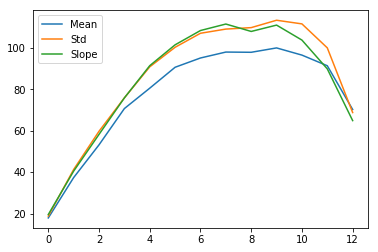

In [285]:
x = np.arange(13)
g = x*(13-x + 1)

plt.plot(temporal_importance.T)
plt.legend(['Mean', 'Std', 'Slope'])

In [ ]:
for metric, value in models['TSF'].items():
    print(metric, np.round(np.mean(value), 3))

### Shapelets

In [437]:
## Needs work
if 'Shapelets' in models.keys():
    scorer = make_scorer(f1_score, average='macro')
    
    if USE_DEFAULT_PARAMETERS:
        model = Pipeline([
                ('reshape', utils.MultiTimeseriesReshape(d=len(DATA))),
                ('clf', ShapeletModel(shapelet_sizes))
            ])
        if OVERSAMPLE:
            model.steps.insert(0, ('sampling', RandomOverSampler()))
            
        models['Shapelets'] = evaluate_model(model, X_train, y_train, X_test, y_test)
    else:
        parameters = {'clf__batch_size':[8,16,32,64],
                      'clf__weight_regularizer':[0.01, 0.05, 0.1, 0.15, 0.2]}
        
        models['Shapelets'] = evaluate_optimal_model(ShapeletModel(shapelet_sizes, max_iter=50, verbose_level=0),
                                                        parameters, scorer, timeseries=True)

## Results

In [159]:
pd.DataFrame.from_dict(models)

,MultipleRegression,LSTM,SVM,RandomForest,GradientBoosting,LSTM_single
f1,"[0.3428571428571428, 0.35294117647058826, 0.10...","[0.3880597014925373, 0.3880597014925373, 0.388...","[0.25, 0.16666666666666669, 0.2702702702702703...","[0.3636363636363637, 0.3157894736842105, 0.117...","[0.3571428571428571, 0.33333333333333337, 0.16...","[0.3880597014925373, 0.3880597014925373, 0.388..."
precision,"[0.2727272727272727, 0.2857142857142857, 0.083...","[0.24074074074074073, 0.24074074074074073, 0.2...","[0.21052631578947367, 0.18181818181818182, 0.2...","[0.4444444444444444, 0.5, 0.25, 0.2, 0.5, 0.42...","[0.3333333333333333, 0.29411764705882354, 0.18...","[0.24074074074074073, 0.24074074074074073, 0.2..."
recall,"[0.46153846153846156, 0.46153846153846156, 0.1...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[0.3076923076923077, 0.15384615384615385, 0.38...","[0.3076923076923077, 0.23076923076923078, 0.07...","[0.38461538461538464, 0.38461538461538464, 0.1...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."


In [140]:
# wm_global_params.append(DATASETS + [OVERSAMPLE, AUGMENT_DATA, AUGMENTED_STD])

# wm_all_results.append(pd.DataFrame.from_dict(models))
# wm_gridsearch_params.append(gridsearches)

In [160]:
global_params.append(DATASETS + ['WM', OVERSAMPLE, AUGMENT_DATA, AUGMENTED_STD])
all_results.append(pd.DataFrame.from_dict(models))
gridsearch_params.append(gridsearches)

In [162]:
# import pickle
# with open('results/All_binary25.pkl', 'wb') as f:
#     pickle.dump([all_results, global_params, gridsearch_params], f)

In [35]:
# with open('variance_results.pkl', 'rb') as f:
#     temp = pickle.load(f)

In [160]:
sum(y)

array([ 30,  12,  19,   6, 219])

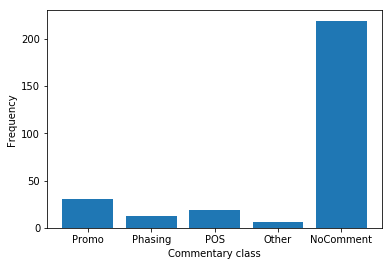

In [162]:
plt.bar(['Promo', 'Phasing', 'POS', 'Other', 'NoComment'], sum(y))
plt.xlabel('Commentary class')
plt.ylabel('Frequency')
plt.savefig('ClassDistribution.eps', format='eps')

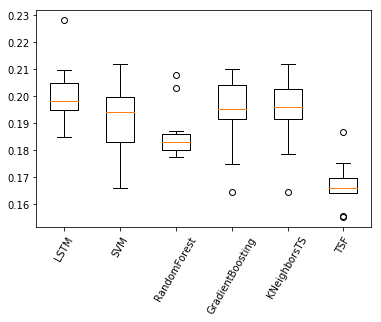

In [391]:
plt.boxplot(all_results[2].loc['f1_macro'])
plt.xticks(range(1, 7), all_results[0].columns, rotation=60)
plt.show()

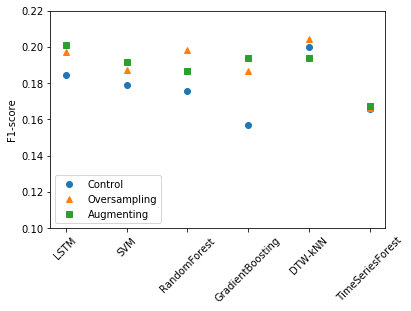

In [535]:
markers = ['o', '^', 's']
for i in range(3):
    means = all_results[i].applymap(np.mean).loc['f1_macro']
    plt.errorbar(range(6), means, fmt=markers[i])
# plt.grid(axis='x')
plt.ylim(0.1,0.22)
plt.ylabel('F1-score')
plt.legend(['Control', 'Oversampling', 'Augmenting'])
plt.xticks(ticks=range(6),labels=['LSTM','SVM','RandomForest','GradientBoosting','DTW-kNN', 'TimeSeriesForest'], rotation=45)
plt.show()

In [217]:
metrics = ['precision_macro', 'recall_macro', 'f1_macro', 'gms_macro']
for model, results in models.items():
    print('\n'+ model)
    print('------------------------')
    for metric, result in results.items():
        print('%s: %.3f' % (metric, np.mean(result)))


LSTM
------------------------
precision_macro: 0.232
recall_macro: 0.184
f1_macro: 0.187
gms_macro: 0.394

SVM
------------------------
precision_macro: 0.192
recall_macro: 0.177
f1_macro: 0.177
gms_macro: 0.386

RandomForest
------------------------
precision_macro: 0.196
recall_macro: 0.174
f1_macro: 0.171
gms_macro: 0.382

GradientBoosting
------------------------
precision_macro: 0.179
recall_macro: 0.168
f1_macro: 0.159
gms_macro: 0.374

KNeighborsTS
------------------------
precision_macro: 0.197
recall_macro: 0.209
f1_macro: 0.200
gms_macro: 0.427

TSF
------------------------
precision_macro: 0.173
recall_macro: 0.170
f1_macro: 0.162
gms_macro: 0.377


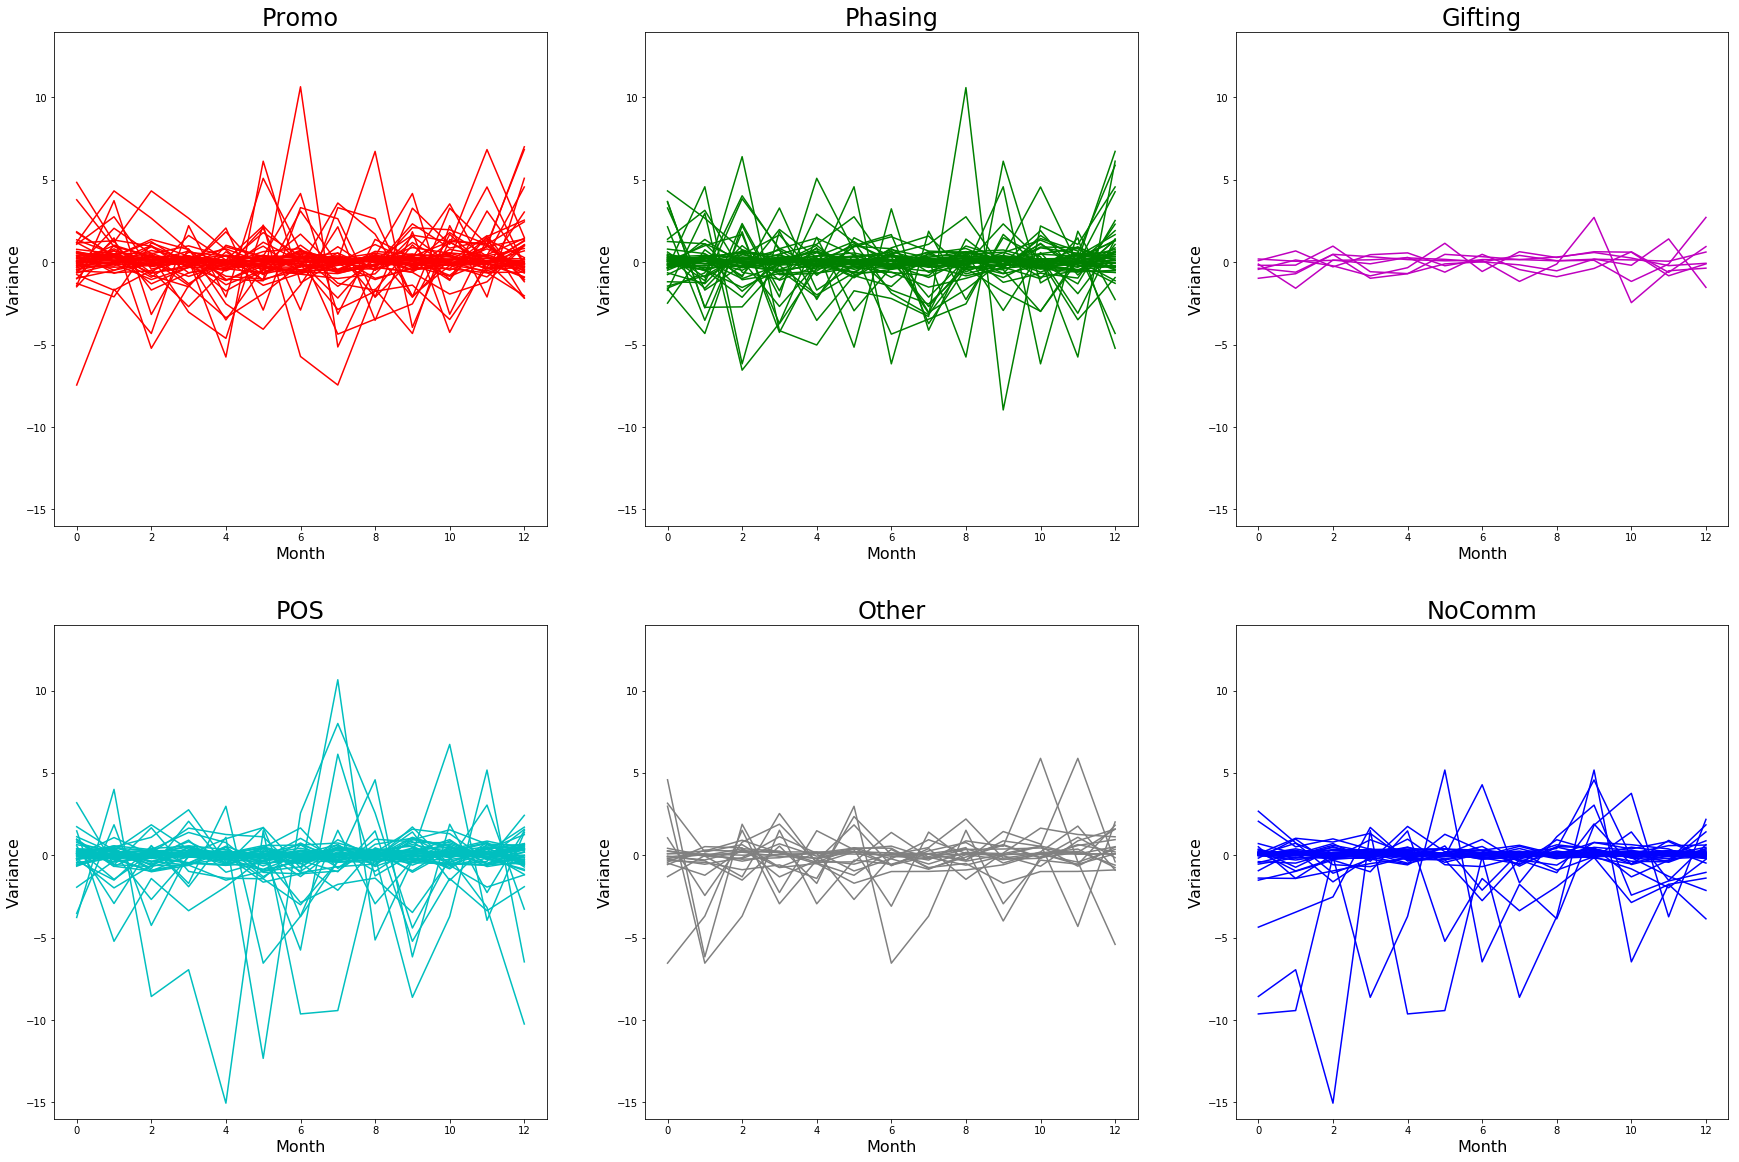

In [673]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(30,20))
colors = ['r','g','m','c', 'grey', 'b']
for i in range(6):
    to_plot = X_train[y_train[:, i]==1]
    for j in range(min(len(to_plot), 50)):
        ax.ravel()[i].plot(to_plot[j], c=colors[i])
        ax.ravel()[i].set_title(classes[i], fontsize=24)
        ax.ravel()[i].set_xlabel("Month", fontsize=16)
        ax.ravel()[i].set_ylabel("Variance", fontsize=16)        
        ax.ravel()[i].set_ylim(-16, 14)
